In [1]:
#@title Import Modules and Constant Variables

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





# Dataset
'''
V2.1
Amplitude
Cosine Instantaneous Phase
Dominant Frequency
Envelope
Instantaneous Bandwith
Instantaneous Frequency
Instantaneous Phase
Reflection Intensity
Second Derivative
Semblance
Sweetness
'''


SEISMIC_ATTRIBUTE_NAME = 'Semblance'

# Images for training
DATA_IMAGES_PATH = os.path.abspath(os.path.join('Datasets', 'SEG2020', 'Images', SEISMIC_ATTRIBUTE_NAME))
assert os.path.exists(DATA_IMAGES_PATH), "Data images path does not exist"

INLINE_DATA_IMAGES_PATH = os.path.join(DATA_IMAGES_PATH, 'Inlines')
assert os.path.exists(INLINE_DATA_IMAGES_PATH), "Inline data images path does not exist"

CROSSLINE_DATA_IMAGES_PATH = os.path.join(DATA_IMAGES_PATH, 'Crosslines')
assert os.path.exists(CROSSLINE_DATA_IMAGES_PATH), "Crossline data images path does not exist"



# Images label
LABEL_IMAGES_PATH = os.path.abspath(os.path.join('Datasets', 'SEG2020', 'Images', 'Labels'))
assert os.path.exists(LABEL_IMAGES_PATH), "Label images path does not exist"

INLINE_LABEL_IMAGES_PATH = os.path.join(LABEL_IMAGES_PATH, 'Inlines')
assert os.path.exists(INLINE_LABEL_IMAGES_PATH), "Inline label images path does not exist"

CROSSLINE_LABEL_IMAGES_PATH = os.path.join(LABEL_IMAGES_PATH, 'Crosslines')
assert os.path.exists(CROSSLINE_LABEL_IMAGES_PATH), "Crossline label images path does not exist"



inline_train_range = (8, 583)
crossline_train_range = (46, 737)

inline_val_range1 = (1, 7)
inline_val_range2 = (584, 590)
crossline_val_range1 = (2, 45) # Exclude crossline 1 due to wrong label
crossline_val_range2 = (738, 782)



X_IMAGE_SIZE = (256, 240)





# Hyperparameters
NUM_CLASSES = 7
EPOCHS = 40
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1
loss_func = torch.nn.CrossEntropyLoss()





# Model saving
MODEL_PATH = 'models'

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

LATEST_MODEL_PATH = os.path.join(MODEL_PATH, 'latest.pth')
BEST_MODEL_NAME = 'unet.pth'
BEST_MODEL_PATH = os.path.join(MODEL_PATH, BEST_MODEL_NAME)





# Performance saving path
IMAGE_SIZE_DESC = f'-{str(X_IMAGE_SIZE[0])}x{str(X_IMAGE_SIZE[1])}'
ARCHITECTURE_DESC = '-BasicUnetv2.1'
EPOCH_DESC = f'-epoch{str(EPOCHS)}'
LEARNING_RATE_DESC = f'-lr{str(LEARNING_RATE)}'
BATCH_SIZE_DESC = f'-bs{str(BATCH_SIZE)}'
ADDITIONAL_DESC = ''
PERFORMANCE_PATH = os.path.join('output', 'performance', SEISMIC_ATTRIBUTE_NAME + IMAGE_SIZE_DESC + ARCHITECTURE_DESC + EPOCH_DESC + LEARNING_RATE_DESC + BATCH_SIZE_DESC + ADDITIONAL_DESC)

if not os.path.exists(PERFORMANCE_PATH):
    os.makedirs(PERFORMANCE_PATH)

torch.Size([3, 1, 1006, 782]) torch.Size([3, 1, 1006, 782])


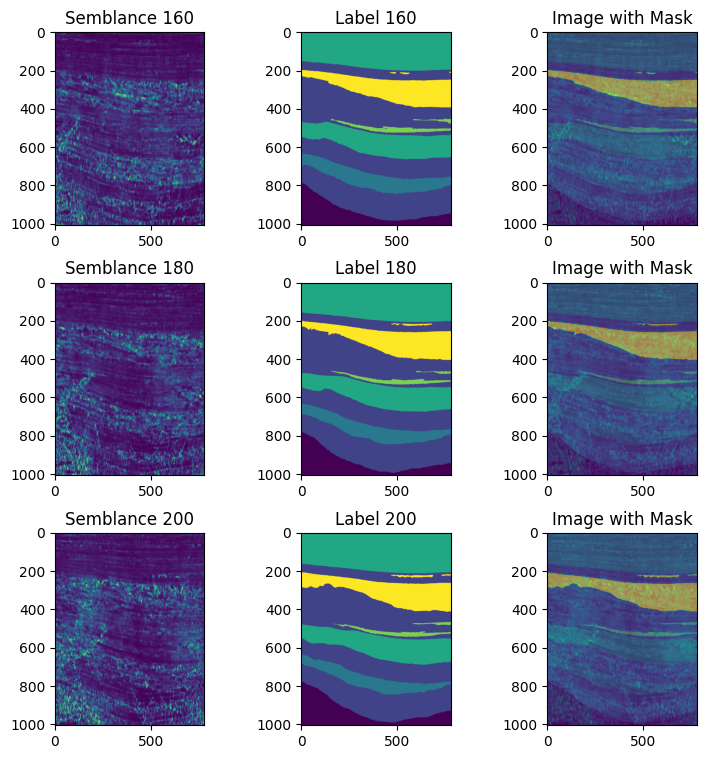

In [2]:
#@title Visualize samples of input and label image

names = ['160', '180', '200']
sample_slice_to_visualize = 'inline' # 'inline' or 'crossline'

if sample_slice_to_visualize == 'inline':
    data_images = [Image.open(os.path.join(INLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(INLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]
else:
    data_images = [Image.open(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]


transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in data_images])
y = torch.stack([transforms(image) for image in label_images])

print(x.shape, y.shape)

fig = plt.figure(figsize=(9, 9))
num_images = len(names)

for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(data_images[i])
    ax.set_title(SEISMIC_ATTRIBUTE_NAME + " " + names[i])

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(label_images[i])
    ax.set_title("Label " + names[i])

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

fig.subplots_adjust(hspace=0.3)
plt.show()

In [3]:
del data_images, label_images, x, y

In [4]:
#@title Splitting data for training and validation

# Data images = train
inline_train_paths = [] # 10.png, 100.png, 101.png, ..., 11.png
inline_val_paths = []
crossline_train_paths = []
crossline_val_paths = []

# Label
inline_train_label_paths = []
inline_val_label_paths = []
crossline_train_label_paths = []
crossline_val_label_paths = []

for i in ("data", "label"):
    # 1. Inline
    if i == "data":
        inline_image_names = [f for f in os.listdir(INLINE_DATA_IMAGES_PATH) if f.endswith('.png')]
    elif i == "label":
        inline_image_names = [f for f in os.listdir(INLINE_LABEL_IMAGES_PATH) if f.endswith('.png')]
    
    # 1.1. Training Images
    # inline_train_image_names = inline_train_image_label_names
    inline_train_image_names = [f for f in inline_image_names if \
                      int(f.split('.')[0]) >= inline_train_range[0] and \
                        int(f.split('.')[0]) <= inline_train_range[1]]

    if i == "data":
        for name in inline_train_image_names:
            inline_train_paths.append(os.path.join(INLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for name in inline_train_image_names:
            inline_train_label_paths.append(os.path.join(INLINE_LABEL_IMAGES_PATH, name))
    
    # 1.2. Validation Images
    # inline_val_image_names = inline_val_image_label_names
    inline_val_image_names = [f for f in inline_image_names if \
                      int(f.split('.')[0]) >= inline_val_range1[0] and \
                        int(f.split('.')[0]) <= inline_val_range1[1]]

    if i == "data":
        for f in inline_image_names:
            if int(f.split('.')[0]) >= inline_val_range2[0] and int(f.split('.')[0]) <= inline_val_range2[1]:
                inline_val_image_names.append(f)
        
        for name in inline_val_image_names:
            # inline_val_paths.append(os.path.abspath(os.path.join(INLINE_DATA_IMAGES_PATH, name)))
            inline_val_paths.append(os.path.join(INLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for f in inline_image_names:
            if int(f.split('.')[0]) >= inline_val_range2[0] and int(f.split('.')[0]) <= inline_val_range2[1]:
                inline_val_image_names.append(f)
        
        for name in inline_val_image_names:
            inline_val_label_paths.append(os.path.join(INLINE_LABEL_IMAGES_PATH, name))



    # 2. crossline
    if i == "data":
        crossline_image_names = [f for f in os.listdir(CROSSLINE_DATA_IMAGES_PATH) if f.endswith('.png')]
    elif i == "label":
        crossline_image_names = [f for f in os.listdir(CROSSLINE_LABEL_IMAGES_PATH) if f.endswith('.png')]
    
    # 2.1. Training Images
    # crossline_train_image_names = crossline_train_image_label_names
    crossline_train_image_names = [f for f in crossline_image_names if \
                      int(f.split('.')[0]) >= crossline_train_range[0] and \
                        int(f.split('.')[0]) <= crossline_train_range[1]]

    if i == "data":
        for name in crossline_train_image_names:
            crossline_train_paths.append(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for name in crossline_train_image_names:
            crossline_train_label_paths.append(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name))
    
    # 2.2. Validation Images
    # crossline_val_image_names = crossline_val_image_label_names
    crossline_val_image_names = [f for f in crossline_image_names if \
                      int(f.split('.')[0]) >= crossline_val_range1[0] and \
                        int(f.split('.')[0]) <= crossline_val_range1[1]]

    if i == "data":
        for f in crossline_image_names:
            if int(f.split('.')[0]) >= crossline_val_range2[0] and int(f.split('.')[0]) <= crossline_val_range2[1]:
                crossline_val_image_names.append(f)
        
        for name in crossline_val_image_names:
            # crossline_val_paths.append(os.path.abspath(os.path.join(crossline_DATA_IMAGES_PATH, name)))
            crossline_val_paths.append(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for f in crossline_image_names:
            if int(f.split('.')[0]) >= crossline_val_range2[0] and int(f.split('.')[0]) <= crossline_val_range2[1]:
                crossline_val_image_names.append(f)
        
        for name in crossline_val_image_names:
            crossline_val_label_paths.append(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name))




# Merge inline and crossline
training_image_paths = inline_train_paths + crossline_train_paths
val_image_paths = inline_val_paths + crossline_val_paths

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(training_image_paths)}")
print(f"Number of validation samples: {len(val_image_paths)}")

# with open('./output/training-image-paths.txt', 'w') as f:
#     for i in training_image_paths:
#         f.write(i + '\n')

# with open('./output/val-image-paths.txt', 'w') as f:
#     for i in val_image_paths:
#         f.write(i + '\n')



training_label_paths = inline_train_label_paths + crossline_train_label_paths
val_label_paths = inline_val_label_paths + crossline_val_label_paths

# with open('./output/training-label-paths.txt', 'w') as f:
#     for i in training_label_paths:
#         f.write(i + '\n')

# with open('./output/val-label-paths.txt', 'w') as f:
#     for i in val_label_paths:
#         f.write(i + '\n')

Number of training samples: 1268
Number of validation samples: 103


In [5]:
del inline_image_names, inline_train_image_names, inline_train_paths, inline_val_image_names, inline_val_paths, crossline_image_names, crossline_train_image_names, crossline_train_paths, crossline_val_image_names, crossline_val_paths

In [6]:
#@title Utilities

class CustomDataset(Dataset):
    color_encoding = [
                ('a', (253, 231, 36)), # Gold
                ('b', (121, 209, 81)), # Light Green
                ('c', (68, 1, 84)), # Dark Purple
                ('d', (64, 67, 135)), # Medium Blue
                ('e', (34, 167, 132)), # Aquamarine
                ('f', (41, 120, 142)) # Cadet Blue
    ]

    def __init__(self, image_paths, label_paths, num_classes=NUM_CLASSES):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.num_classes = num_classes
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')

        image = self.transforms(image)
        resized_image = T.Resize(X_IMAGE_SIZE)(image)

        label = Image.open(self.label_paths[idx])
        label = label.convert('RGB')

        label = np.array(label)
        label = self.label_for_cross_entropy(label)
        label = Image.fromarray(label)
        resized_label = T.Resize(X_IMAGE_SIZE)(label)
        resized_label = np.array(resized_label)

        return resized_image, torch.from_numpy(resized_label).long()

    def label_for_cross_entropy(self, label):
        semantic_map = np.zeros(label.shape[:-1])
        semantic_map.fill(self.num_classes - 1)

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index

        return semantic_map

    def __len__(self):
        return len(self.label_paths)



def reverse_one_hot(image):
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)

    return x



# IoU Metric
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)

    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5

    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)



def val(model, dataloader):
    print('\n\n\t------- Start validating -------')
    accuracy_arr = []
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()

        val_loss_record = []

        for _, (val_data, val_label) in enumerate(dataloader):
            val_data_cuda = val_data.cuda()
            val_label_cuda = val_label.cuda()

            val_output = model(val_data_cuda)
            val_loss = loss_func(val_output, val_label_cuda)

            val_output = val_output.squeeze()
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())

            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)

            val_loss_record.append(val_loss.item())

        mean_accuracy = np.mean(accuracy_arr)

        miou_list = per_class_iu(hist)
        mean_iou = np.mean(miou_list)
        
        # wIoU SEG 2020 paper
        class_weight = hist.sum(axis=1) / hist.sum()
        weighted_iou = (class_weight[class_weight > 0] * miou_list[class_weight > 0]).sum()

        val_loss_mean = np.mean(val_loss_record)

        print('Mean validation loss: {}\nMean validation IoU: {}\nWeighted validation IoU: {}'.format(val_loss_mean, mean_iou, weighted_iou))
        
        return mean_accuracy, mean_iou, val_loss_mean

In [7]:
#@title Training and validation data preparation

train_dataset = CustomDataset(training_image_paths, training_label_paths)
val_dataset = CustomDataset(val_image_paths, val_label_paths)

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

158 steps per epoch


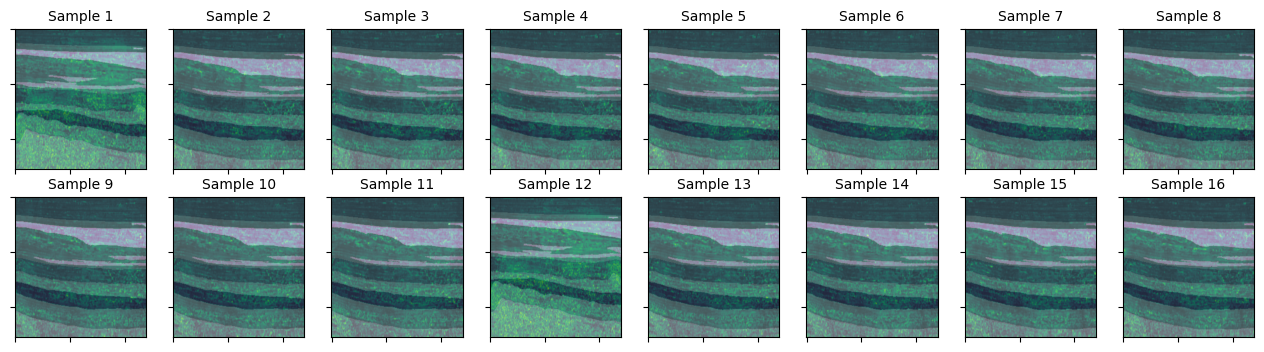

In [8]:
#@title Visualize training dataset

max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, label = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(label.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

plt.show()

In [9]:
del train_dataset, val_dataset

In [10]:
#@title Modeling Saiful - Basic U-Net version 2.1

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x



class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DoubleConvBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        return x



class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size)
    
    def forward(self, x1, x2):
        # x1 from contracting path (downsampling/encoder)
        x2 = self.upconv(x2) 

        # Crop x2 to match the shape of x1
        if x2.shape != x1.shape:
            x2 = TF.resize(x2, size=x1.shape[2:])
        
        # Or pad the expanding path feature map
        # if x2.shape != x1.shape:
        #     diffY = x1.size()[2] - x2.size()[2]
        #     diffX = x1.size()[3] - x2.size()[3]
        #     x2 = F.pad(x2, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x1, x2], dim=1)

        return x



class OutputBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(OutputBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        # self.activation = nn.Softmax()
    
    def forward(self,x):
        x = self.conv(x)
        # x = self.activation(x)

        return x



class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=7, starting_filter=64):
        super(UNet, self).__init__()
        self.downsampling = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.down_conv1 = DoubleConvBlock(in_channels, starting_filter)
        self.down_conv2 = DoubleConvBlock(starting_filter, starting_filter * 2)
        self.down_conv3 = DoubleConvBlock(starting_filter * 2, starting_filter * 4)
        self.down_conv4 = DoubleConvBlock(starting_filter * 4, starting_filter * 8)

        self.middle = DoubleConvBlock(starting_filter * 8, starting_filter * 16)

        self.up1 = UpBlock(starting_filter * 16, starting_filter * 8)
        self.up_conv1 = DoubleConvBlock(starting_filter * 16, starting_filter * 8)

        self.up2 = UpBlock(starting_filter * 8, starting_filter * 4)
        self.up_conv2 = DoubleConvBlock(starting_filter * 8, starting_filter * 4)

        self.up3 = UpBlock(starting_filter * 4, starting_filter * 2)
        self.up_conv3 = DoubleConvBlock(starting_filter * 4, starting_filter * 2)

        self.up4 = UpBlock(starting_filter * 2, starting_filter)
        self.up_conv4 = DoubleConvBlock(starting_filter * 2, starting_filter)

        self.final = OutputBlock(starting_filter, n_classes)
    
    def forward(self, x):
        # Contracting Path (Encoder)
        down1 = self.down_conv1(x)
        x = self.downsampling(down1)
        x = self.dropout(x)

        down2 = self.down_conv2(x)
        x = self.downsampling(down2)
        x = self.dropout(x)

        down3 = self.down_conv3(x)
        x = self.downsampling(down3)
        x = self.dropout(x)

        down4 = self.down_conv4(x)
        x = self.downsampling(down4)
        x = self.dropout(x)



        # Bottleneck Layer
        x = self.middle(x)



        # Expansive Path (Decoder)
        x = self.up1(down4, x)
        x = self.dropout(x)
        x = self.up_conv1(x)

        x = self.up2(down3, x)
        x = self.dropout(x)
        x = self.up_conv2(x)

        x = self.up3(down2, x)
        x = self.dropout(x)
        x = self.up_conv3(x)

        x = self.up4(down1, x)
        x = self.dropout(x)
        x = self.up_conv4(x)

        # Output Layer
        x = self.dropout(x)
        x = self.final(x)

        return x

In [ ]:
#@title Training

torch.cuda.empty_cache()
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())

train_loss_hist = []
val_loss_hist = []

max_miou = 0
max_miou_epoch = 0
train_iou_hist = []
val_iou_hist = []

start_training = time.time()
start_trianing_so_far = time.time()

for epoch in range(EPOCHS):
    model.train()
    start_epoch = time.time()

    print()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()

        output = model(data)
        loss = loss_func(output, label)

        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        output = reverse_one_hot(output)
        output = np.array(output.cpu())

        optimizer.zero_grad()
        loss.backward()

        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) # Gradient Clipping
        optimizer.step()
        
        loss_record.append(loss.item())
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)

    tq.close()
    epoch_time_elapsed = time.time() - start_epoch
    training_so_far_time_elapsed = time.time() - start_trianing_so_far
    loss_train_mean = np.mean(loss_record)
    train_loss_hist = train_loss_hist + [loss_train_mean]

    miou_list = per_class_iu(hist)
    mean_iou = np.mean(miou_list)
    train_iou_hist = train_iou_hist + [mean_iou]

    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))
    print('Epoch {} completed in {:.0f}m {:.0f}s'.format(str(epoch + 1), epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    print('So far it takes: {:.0f}m {:.0f}s'.format(training_so_far_time_elapsed // 60, training_so_far_time_elapsed % 60))

    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), LATEST_MODEL_PATH)

    # Validate save best model
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(' *** Saving the best model with mIoU = {}'.format(mean_iou))
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))
    


training_time_elapsed = time.time() - start_training
training_duration = '{:.0f}m {:.0f}s'.format(training_time_elapsed // 60, training_time_elapsed % 60)
print(f'Training completed in {training_duration}')

Epoch 1/40: 100%|██████████| 1264/1264 [03:19<00:00,  6.35it/s, loss=0.402583]


loss for train : 0.640293
IoU for train : 0.409853
Epoch 1 completed in 3m 19s
So far it takes: 3m 19s


	------- Start validating -------


d:\Saiful\env-saiful\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Saiful\env-saiful\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean validation loss: 0.32396432069631725
Mean validation IoU: 0.6811890631292555
Weighted validation IoU: 0.8040690600997425
 *** Saving the best model with mIoU = 0.6811890631292555



Epoch 2/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.98it/s, loss=0.205566]


loss for train : 0.271627
IoU for train : 0.741380
Epoch 2 completed in 2m 38s
So far it takes: 6m 12s


	------- Start validating -------
Mean validation loss: 0.2593823465017172
Mean validation IoU: 0.7273617528860171
Weighted validation IoU: 0.8328216009392966
 *** Saving the best model with mIoU = 0.7273617528860171



Epoch 3/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.02it/s, loss=0.189953]


loss for train : 0.206240
IoU for train : 0.797711
Epoch 3 completed in 2m 38s
So far it takes: 9m 2s


	------- Start validating -------
Mean validation loss: 0.28691430160632503
Mean validation IoU: 0.7404105557971393
Weighted validation IoU: 0.8332582219217005
 *** Saving the best model with mIoU = 0.7404105557971393



Epoch 4/40: 100%|██████████| 1264/1264 [02:41<00:00,  7.84it/s, loss=0.151445]


loss for train : 0.171667
IoU for train : 0.822057
Epoch 4 completed in 2m 41s
So far it takes: 11m 55s


	------- Start validating -------
Mean validation loss: 0.22839177342561576
Mean validation IoU: 0.7790517142144325
Weighted validation IoU: 0.8550188583069633
 *** Saving the best model with mIoU = 0.7790517142144325



Epoch 5/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.98it/s, loss=0.168374]


loss for train : 0.149841
IoU for train : 0.837320
Epoch 5 completed in 2m 38s
So far it takes: 14m 45s


	------- Start validating -------
Mean validation loss: 0.1901640146970749
Mean validation IoU: 0.7929785536013266
Weighted validation IoU: 0.8761721004604743
 *** Saving the best model with mIoU = 0.7929785536013266



Epoch 6/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.99it/s, loss=0.123850]


loss for train : 0.135349
IoU for train : 0.847050
Epoch 6 completed in 2m 38s
So far it takes: 17m 35s


	------- Start validating -------
Mean validation loss: 0.19528360320971563
Mean validation IoU: 0.7921005393820916
Weighted validation IoU: 0.8760761534023502
Best mIoU: 0.7929785536013266 at epoch 5



Epoch 7/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.01it/s, loss=0.112833]


loss for train : 0.121882
IoU for train : 0.856722
Epoch 7 completed in 2m 38s
So far it takes: 20m 24s


	------- Start validating -------
Mean validation loss: 0.19301907030435708
Mean validation IoU: 0.8003186158849015
Weighted validation IoU: 0.8781089568659416
 *** Saving the best model with mIoU = 0.8003186158849015



Epoch 8/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.94it/s, loss=0.118955]


loss for train : 0.116533
IoU for train : 0.860909
Epoch 8 completed in 2m 39s
So far it takes: 23m 16s


	------- Start validating -------
Mean validation loss: 0.18553084077743384
Mean validation IoU: 0.8131653525326463
Weighted validation IoU: 0.8820431425474621
 *** Saving the best model with mIoU = 0.8131653525326463



Epoch 9/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.92it/s, loss=0.107071]


loss for train : 0.107937
IoU for train : 0.867936
Epoch 9 completed in 2m 40s
So far it takes: 26m 7s


	------- Start validating -------
Mean validation loss: 0.1831537290261342
Mean validation IoU: 0.8068122020023901
Weighted validation IoU: 0.8863131466834577
Best mIoU: 0.8131653525326463 at epoch 8



Epoch 10/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.02it/s, loss=0.095697]


loss for train : 0.100653
IoU for train : 0.873553
Epoch 10 completed in 2m 38s
So far it takes: 28m 57s


	------- Start validating -------
Mean validation loss: 0.1913759605242656
Mean validation IoU: 0.8123289521679377
Weighted validation IoU: 0.8848521086372468
Best mIoU: 0.8131653525326463 at epoch 8



Epoch 11/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.02it/s, loss=0.088833]


loss for train : 0.097225
IoU for train : 0.876278
Epoch 11 completed in 2m 38s
So far it takes: 31m 46s


	------- Start validating -------
Mean validation loss: 0.19302981633406419
Mean validation IoU: 0.8122284940750157
Weighted validation IoU: 0.8857002493313544
Best mIoU: 0.8131653525326463 at epoch 8



Epoch 12/40: 100%|██████████| 1264/1264 [02:36<00:00,  8.05it/s, loss=0.090358]


loss for train : 0.094763
IoU for train : 0.877879
Epoch 12 completed in 2m 37s
So far it takes: 34m 35s


	------- Start validating -------
Mean validation loss: 0.16434586220062697
Mean validation IoU: 0.8289060348131932
Weighted validation IoU: 0.8977501528047986
 *** Saving the best model with mIoU = 0.8289060348131932



Epoch 13/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.00it/s, loss=0.086431]


loss for train : 0.089074
IoU for train : 0.883172
Epoch 13 completed in 2m 38s
So far it takes: 37m 25s


	------- Start validating -------
Mean validation loss: 0.18043967622977036
Mean validation IoU: 0.8265284429735503
Weighted validation IoU: 0.8968216398934669
Best mIoU: 0.8289060348131932 at epoch 12



Epoch 14/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.084496]


loss for train : 0.085844
IoU for train : 0.885923
Epoch 14 completed in 2m 39s
So far it takes: 40m 16s


	------- Start validating -------
Mean validation loss: 0.15938724520114753
Mean validation IoU: 0.833734224466112
Weighted validation IoU: 0.9018278080062084
 *** Saving the best model with mIoU = 0.833734224466112



Epoch 15/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.96it/s, loss=0.080198]


loss for train : 0.082467
IoU for train : 0.889175
Epoch 15 completed in 2m 39s
So far it takes: 43m 7s


	------- Start validating -------
Mean validation loss: 0.17001162297450578
Mean validation IoU: 0.8336252839371959
Weighted validation IoU: 0.9023863782513364
Best mIoU: 0.833734224466112 at epoch 14



Epoch 16/40: 100%|██████████| 1264/1264 [02:40<00:00,  7.86it/s, loss=0.077191]


loss for train : 0.082228
IoU for train : 0.889360
Epoch 16 completed in 2m 41s
So far it takes: 45m 60s


	------- Start validating -------
Mean validation loss: 0.18746107931320483
Mean validation IoU: 0.8281937408723127
Weighted validation IoU: 0.8940036968708249
Best mIoU: 0.833734224466112 at epoch 14



Epoch 17/40: 100%|██████████| 1264/1264 [02:48<00:00,  7.48it/s, loss=0.076135]


loss for train : 0.077576
IoU for train : 0.893700
Epoch 17 completed in 2m 49s
So far it takes: 49m 1s


	------- Start validating -------
Mean validation loss: 0.18265376698512298
Mean validation IoU: 0.8342888685746634
Weighted validation IoU: 0.9016627736137562
 *** Saving the best model with mIoU = 0.8342888685746634



Epoch 18/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.96it/s, loss=0.071841]


loss for train : 0.076584
IoU for train : 0.894127
Epoch 18 completed in 2m 39s
So far it takes: 51m 52s


	------- Start validating -------
Mean validation loss: 0.16554110153363302
Mean validation IoU: 0.8391332714149689
Weighted validation IoU: 0.903633511739996
 *** Saving the best model with mIoU = 0.8391332714149689



Epoch 19/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.066371]


loss for train : 0.073477
IoU for train : 0.897353
Epoch 19 completed in 2m 39s
So far it takes: 54m 43s


	------- Start validating -------
Mean validation loss: 0.17841053983339897
Mean validation IoU: 0.8380462127381609
Weighted validation IoU: 0.9036698709957537
Best mIoU: 0.8391332714149689 at epoch 18



Epoch 20/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.99it/s, loss=0.072286]


loss for train : 0.072483
IoU for train : 0.897623
Epoch 20 completed in 2m 38s
So far it takes: 57m 33s


	------- Start validating -------
Mean validation loss: 0.20098170408835778
Mean validation IoU: 0.8328058214161306
Weighted validation IoU: 0.8991208032497389
Best mIoU: 0.8391332714149689 at epoch 18



Epoch 21/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.94it/s, loss=0.068182]


loss for train : 0.070421
IoU for train : 0.900239
Epoch 21 completed in 2m 39s
So far it takes: 60m 24s


	------- Start validating -------
Mean validation loss: 0.16199981879729491
Mean validation IoU: 0.846056827799791
Weighted validation IoU: 0.9078996578747809
 *** Saving the best model with mIoU = 0.846056827799791



Epoch 22/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.95it/s, loss=0.075590]


loss for train : 0.068171
IoU for train : 0.902224
Epoch 22 completed in 2m 39s
So far it takes: 63m 16s


	------- Start validating -------
Mean validation loss: 0.16807392296882775
Mean validation IoU: 0.8406769703451736
Weighted validation IoU: 0.9051003268149003
Best mIoU: 0.846056827799791 at epoch 21



Epoch 23/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.061486]


loss for train : 0.066542
IoU for train : 0.904069
Epoch 23 completed in 2m 39s
So far it takes: 66m 7s


	------- Start validating -------
Mean validation loss: 0.1882786790911968
Mean validation IoU: 0.8375061922913583
Weighted validation IoU: 0.9047044455296435
Best mIoU: 0.846056827799791 at epoch 21



Epoch 24/40: 100%|██████████| 1264/1264 [02:40<00:00,  7.89it/s, loss=0.064145]


loss for train : 0.066218
IoU for train : 0.904152
Epoch 24 completed in 2m 40s
So far it takes: 68m 59s


	------- Start validating -------
Mean validation loss: 0.17891950332201445
Mean validation IoU: 0.8435544397953697
Weighted validation IoU: 0.9063545478646837
Best mIoU: 0.846056827799791 at epoch 21



Epoch 25/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.97it/s, loss=0.061517]


loss for train : 0.065813
IoU for train : 0.904640
Epoch 25 completed in 2m 39s
So far it takes: 71m 49s


	------- Start validating -------
Mean validation loss: 0.17973618323986346
Mean validation IoU: 0.8402896919174285
Weighted validation IoU: 0.9039982051162563
Best mIoU: 0.846056827799791 at epoch 21



Epoch 26/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.060041]


loss for train : 0.062792
IoU for train : 0.907866
Epoch 26 completed in 2m 39s
So far it takes: 74m 40s


	------- Start validating -------
Mean validation loss: 0.18746330646368173
Mean validation IoU: 0.8357038649739214
Weighted validation IoU: 0.9061857814848022
Best mIoU: 0.846056827799791 at epoch 21



Epoch 27/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.99it/s, loss=0.060182]


loss for train : 0.062170
IoU for train : 0.908572
Epoch 27 completed in 2m 38s
So far it takes: 77m 30s


	------- Start validating -------
Mean validation loss: 0.19006841744367892
Mean validation IoU: 0.8388729830005263
Weighted validation IoU: 0.9052836281999149
Best mIoU: 0.846056827799791 at epoch 21



Epoch 28/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.94it/s, loss=0.057095]


loss for train : 0.061474
IoU for train : 0.908916
Epoch 28 completed in 2m 39s
So far it takes: 80m 21s


	------- Start validating -------
Mean validation loss: 0.17318568779872015
Mean validation IoU: 0.8457796219538792
Weighted validation IoU: 0.9103406682537185
Best mIoU: 0.846056827799791 at epoch 21



Epoch 29/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.064551]


loss for train : 0.060413
IoU for train : 0.910437
Epoch 29 completed in 2m 39s
So far it takes: 83m 12s


	------- Start validating -------
Mean validation loss: 0.1649415590442144
Mean validation IoU: 0.8434753655132766
Weighted validation IoU: 0.9095673391446081
Best mIoU: 0.846056827799791 at epoch 21



Epoch 30/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.96it/s, loss=0.062883]


loss for train : 0.059974
IoU for train : 0.910663
Epoch 30 completed in 2m 39s
So far it takes: 86m 3s


	------- Start validating -------
Mean validation loss: 0.17105042877105567
Mean validation IoU: 0.8401374745568525
Weighted validation IoU: 0.909185146910744
Best mIoU: 0.846056827799791 at epoch 21



Epoch 31/40: 100%|██████████| 1264/1264 [02:37<00:00,  8.01it/s, loss=0.285496]


loss for train : 0.154251
IoU for train : 0.855099
Epoch 31 completed in 2m 38s
So far it takes: 88m 52s


	------- Start validating -------
Mean validation loss: 0.4898136785397163
Mean validation IoU: 0.6597095635243114
Weighted validation IoU: 0.7733620497599095
Best mIoU: 0.846056827799791 at epoch 21



Epoch 32/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.133459]


loss for train : 0.168136
IoU for train : 0.824125
Epoch 32 completed in 2m 39s
So far it takes: 91m 43s


	------- Start validating -------
Mean validation loss: 0.20830686046526983
Mean validation IoU: 0.7908664975640601
Weighted validation IoU: 0.8763954951270637
Best mIoU: 0.846056827799791 at epoch 21



Epoch 33/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.91it/s, loss=0.104799]


loss for train : 0.108575
IoU for train : 0.865064
Epoch 33 completed in 2m 40s
So far it takes: 94m 34s


	------- Start validating -------
Mean validation loss: 0.17903747925391564
Mean validation IoU: 0.8152386599581533
Weighted validation IoU: 0.8910573180334798
Best mIoU: 0.846056827799791 at epoch 21



Epoch 34/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.92it/s, loss=0.085706]


loss for train : 0.091102
IoU for train : 0.880368
Epoch 34 completed in 2m 40s
So far it takes: 97m 25s


	------- Start validating -------
Mean validation loss: 0.16620990232779428
Mean validation IoU: 0.8292347802988618
Weighted validation IoU: 0.8989958292878624
Best mIoU: 0.846056827799791 at epoch 21



Epoch 35/40: 100%|██████████| 1264/1264 [02:41<00:00,  7.85it/s, loss=0.078823]


loss for train : 0.080925
IoU for train : 0.889972
Epoch 35 completed in 2m 41s
So far it takes: 100m 18s


	------- Start validating -------
Mean validation loss: 0.1643281728029251
Mean validation IoU: 0.8373791105516257
Weighted validation IoU: 0.9037204968771524
Best mIoU: 0.846056827799791 at epoch 21



Epoch 36/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.99it/s, loss=0.077675]


loss for train : 0.076040
IoU for train : 0.894551
Epoch 36 completed in 2m 38s
So far it takes: 103m 8s


	------- Start validating -------
Mean validation loss: 0.1727668711772332
Mean validation IoU: 0.8345443321060536
Weighted validation IoU: 0.9018288409395614
Best mIoU: 0.846056827799791 at epoch 21



Epoch 37/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.98it/s, loss=0.064636]


loss for train : 0.070945
IoU for train : 0.899419
Epoch 37 completed in 2m 38s
So far it takes: 105m 58s


	------- Start validating -------
Mean validation loss: 0.1821732589831719
Mean validation IoU: 0.8398383513649932
Weighted validation IoU: 0.9037632976091238
Best mIoU: 0.846056827799791 at epoch 21



Epoch 38/40: 100%|██████████| 1264/1264 [02:38<00:00,  7.97it/s, loss=0.069553]


loss for train : 0.068420
IoU for train : 0.901890
Epoch 38 completed in 2m 38s
So far it takes: 108m 48s


	------- Start validating -------
Mean validation loss: 0.17942920556435218
Mean validation IoU: 0.8437398298093226
Weighted validation IoU: 0.907263083942551
Best mIoU: 0.846056827799791 at epoch 21



Epoch 39/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.95it/s, loss=0.065309]


loss for train : 0.065895
IoU for train : 0.904244
Epoch 39 completed in 2m 39s
So far it takes: 111m 39s


	------- Start validating -------
Mean validation loss: 0.1755728033872751
Mean validation IoU: 0.837384075771017
Weighted validation IoU: 0.9047428005674888
Best mIoU: 0.846056827799791 at epoch 21



Epoch 40/40: 100%|██████████| 1264/1264 [02:39<00:00,  7.93it/s, loss=0.065981]


loss for train : 0.064755
IoU for train : 0.905103
Epoch 40 completed in 2m 39s
So far it takes: 114m 30s


	------- Start validating -------
Mean validation loss: 0.18133618911871544
Mean validation IoU: 0.8422344361305986
Weighted validation IoU: 0.9077403750381439
Best mIoU: 0.846056827799791 at epoch 21
Training completed in 114m 42s


In [12]:
del dataloader_train, dataloader_val, data, label, output

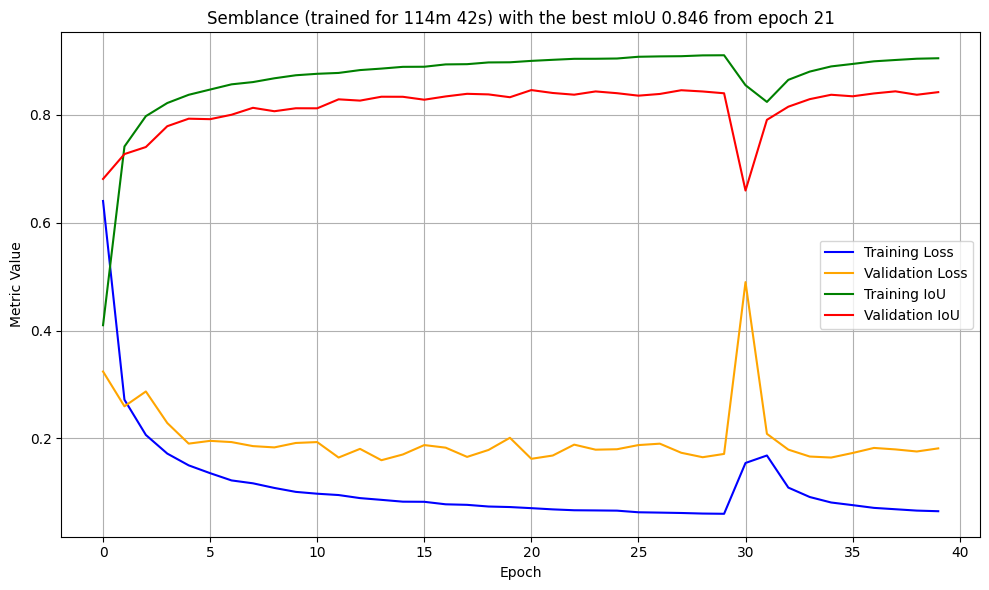

In [13]:
#@title Visualize Training and Validation Curve

plt.figure(figsize=(10, 6))

plt.plot(train_loss_hist, label='Training Loss', color='blue')
plt.plot(val_loss_hist, label='Validation Loss', color='orange')
plt.plot(train_iou_hist, label='Training IoU', color='green')
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title(f'{SEISMIC_ATTRIBUTE_NAME} (trained for {training_duration}) with the best mIoU {max_miou:.3f} from epoch {max_miou_epoch}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PERFORMANCE_PATH, 'training-curve.png'))
plt.show()

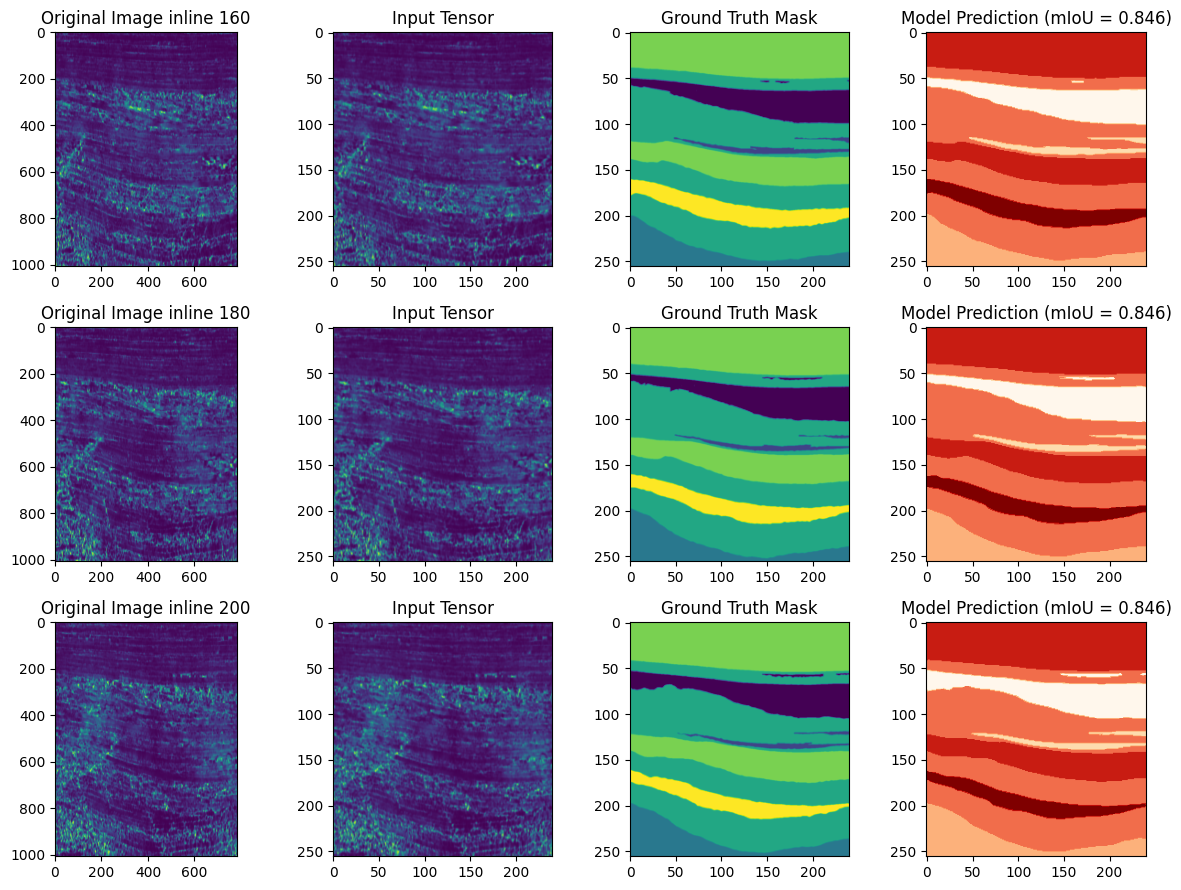

In [14]:
#@title Model Prediction on Sample Images

color_encoding = [
        ('a', (253, 231, 36)), # Gold
        ('b', (121, 209, 81)), # Light Green
        ('c', (68, 1, 84)), # Dark Purple
        ('d', (64, 67, 135)), # Medium Blue
        ('e', (34, 167, 132)), # Aquamarine
        ('f', (41, 120, 142)) # Cadet Blue
]

def label_for_cross_entropy(label):
    semantic_map = np.zeros(label.shape[:-1])
    semantic_map.fill(NUM_CLASSES - 1)

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index

    return semantic_map


# Load Best Model
model = UNet().to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
torch.save(model.state_dict(), os.path.join(PERFORMANCE_PATH, BEST_MODEL_NAME))
model = model.to(device)
model.eval()

slice_to_visualize = 'inline' # 'inline' or 'crossline'
names = ['160', '180', '200']

if slice_to_visualize == 'inline':
    data_images = [Image.open(os.path.join(INLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(INLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]
else:
    data_images = [Image.open(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]

data_images = [i.convert('RGB') for i in data_images]

label_images = [i.convert('RGB') for i in label_images]
label_images = [np.array(i) for i in label_images]
label_images = [label_for_cross_entropy(i) for i in label_images]
label_images = [Image.fromarray(i) for i in label_images]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize(X_IMAGE_SIZE)])
x = torch.stack([transforms(image) for image in data_images])
y = torch.stack([transforms(mask) for mask in label_images])

x = x.to(device)
outputs = model(x)
outputs =  outputs.squeeze()
outputs = np.array(outputs.detach().cpu())

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))

for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(data_images[i])
    ax.set_title(f'Original Image {slice_to_visualize} {names[i]}')

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    x_numpy = x[i].squeeze().cpu().numpy()
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    ax.imshow(x_numpy.squeeze())
    ax.set_title('Input Tensor')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze())
    ax.set_title('Ground Truth Mask')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    output = outputs[i].squeeze()
    output_tensor = torch.from_numpy(output)
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    ax.imshow(class_labels_np, cmap="OrRd")
    ax.set_title(f"Model Prediction (mIoU = {max_miou:.3f})")

plt.tight_layout()
plt.savefig(os.path.join(PERFORMANCE_PATH, 'prediction.png'))
plt.show()

In [15]:
del model, data_images, label_images, x, y, outputs